In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import AstroChemNet.data_processing as dp
from AstroChemNet.inference import (
    Inference
)
import AstroChemNet.data_loading as dl
from ..autoencoder.config import (
    GeneralConfig,
    AEConfig,
)
from ..autoencoder.nn import (
    Autoencoder,
)
from ..autoencoder.training import (
    load_autoencoder
)

species_of_interest = ["H", "H2", "O", "C", "N", "SPlus", "MG", "SIPlus", "CL", "CPlus", "BULK_CO", "BULK_H", "E_minus", "CO", "BULK_CO"]
#species_of_interest = ["H", "H2", "O", "C", "N", "CL", "E_minus", "CO"]

In [ ]:
autoencoder = load_autoencoder(GeneralConfig, AEConfig)

processing_functions = dp.Processing(
    GeneralConfig,
    AEConfig,
)
inference_functions = Inference(GeneralConfig, processing_functions, autoencoder)

loaded_column_names = GeneralConfig.metadata + GeneralConfig.physical_parameters + GeneralConfig.species
training_np, validation_np = dl.load_datasets(GeneralConfig, loaded_column_names)
del training_np

Loading Pretrained Model
Inference Mode Activated (parameters frozen)
Total Parameters: 280088


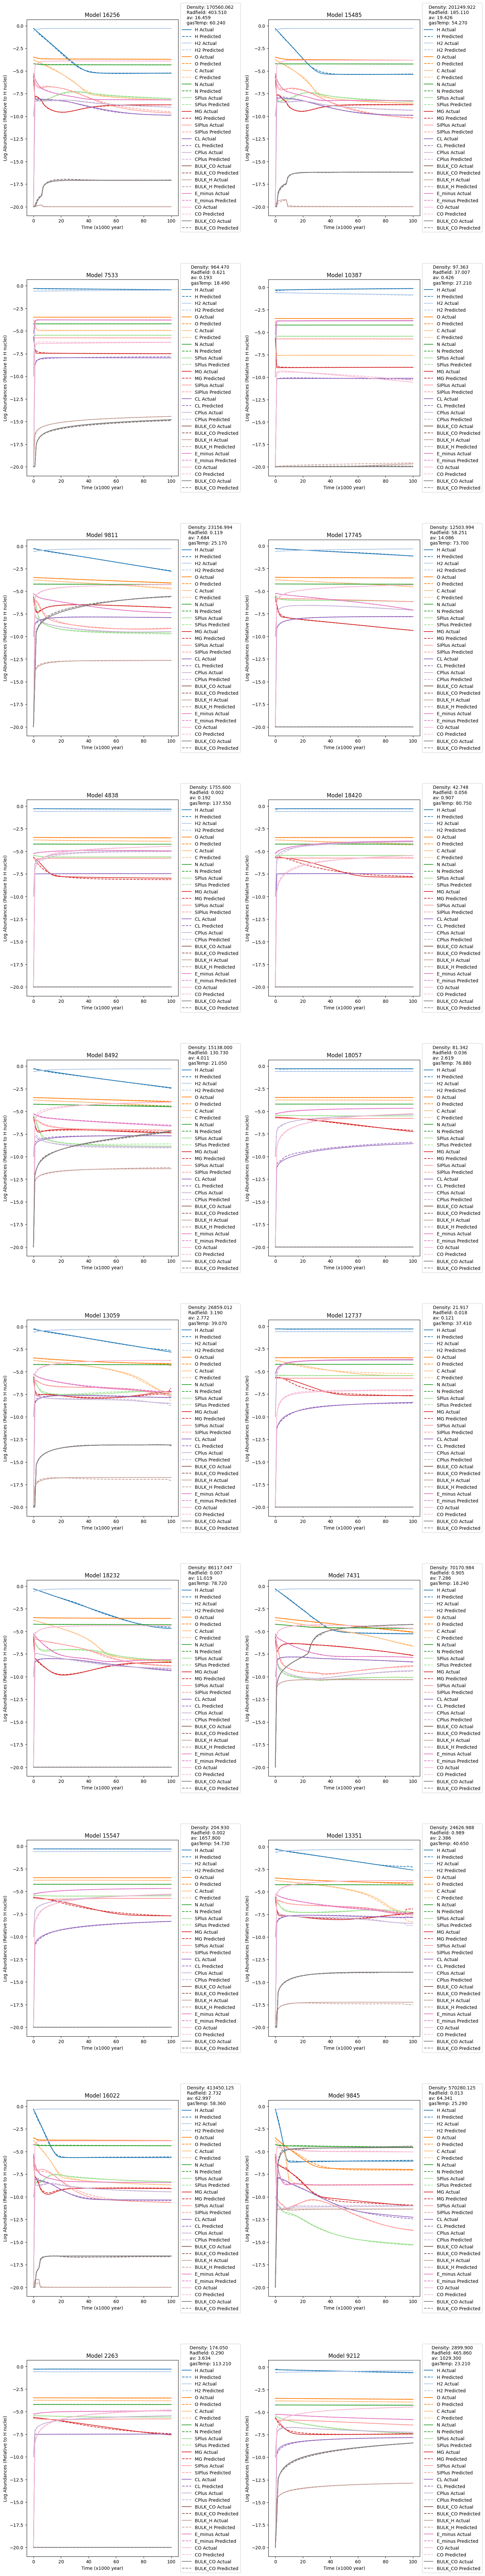

In [ ]:
num_plots = 2 * 2
sampled_model_indices = random.sample(range(9000), num_plots)

fig, axes = plt.subplots(int(num_plots//2), 2, figsize=(15, num_plots*4))
axes = axes.flatten()

for i, model_idx_num in enumerate(sampled_model_indices):
    curr_df = validation_np[validation_np["Model"] == model_idx_num]
    curr_species_np = curr_df[GeneralConfig.species].to_numpy()
    
    latents = inference_functions.encode(curr_species_np)
    abundances = inference_functions.decode(latents)
    
    res_df = pd.DataFrame(abundances, columns=GeneralConfig.species)
        
    timesteps = np.arange(len(curr_df))
    colors = plt.colormaps.get_cmap('tab20')
    
    for idx, species in enumerate(species_of_interest):        
        plt.plot(
            curr_df["Time"], 
            np.log10(curr_df[species])[:len(timesteps)], 
            label=f"{species} Actual", 
            color=colors(idx), 
            linestyle="-"
        )
        plt.plot(
            curr_df["Time"],
            np.log10(res_df[species])[:len(timesteps)], 
            label=f"{species} Predicted", 
            color=colors(idx), 
            linestyle="--"
        )
    
    plt.xlabel("Time")
    plt.ylabel("Log Abundances (Relative to H nuclei)")
    plt.title(f"Model {int(model_idx)}")
    
    output_path = f"plots/abundances_vs_time/model_{int(model_idx)}.png"
    single_fig = plt.figure(figsize=(10, 8))
    
    #plt.savefig(output_path, dpi=200, bbox_inches="tight")
    plt.close(single_fig)
    
plt.tight_layout()
plt.show()
plt.close(fig)

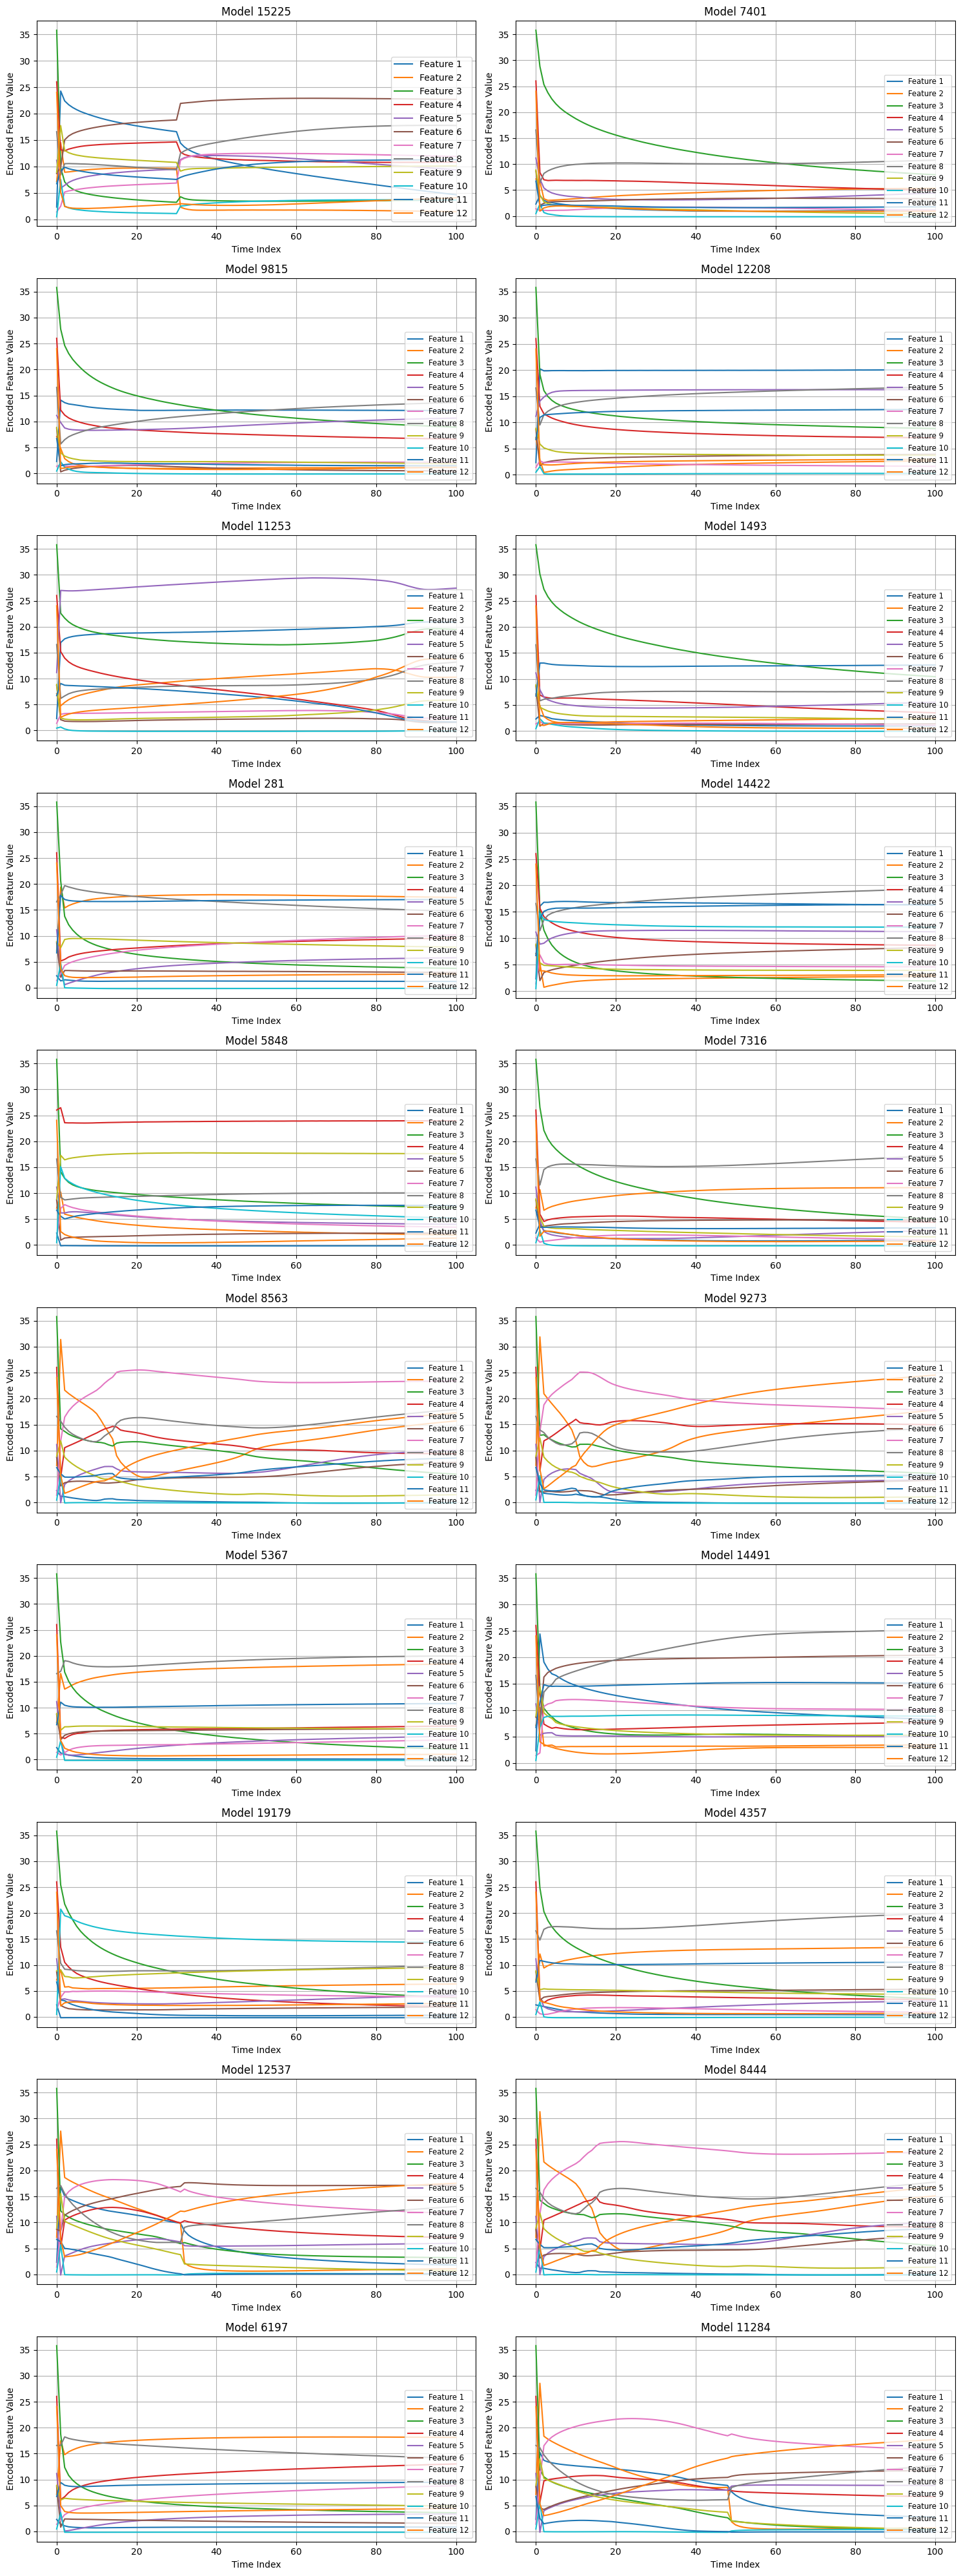

In [ ]:
num_plots = 10 * 2
sampled_model_indices = random.sample(range(9000), num_plots)

fig, axes = plt.subplots(num_plots, 2, figsize=(20, num_plots*6))

for plot_idx, model_idx_num in enumerate(sampled_model_indices):
    model_idx = validation_t[:, 1].unique()[model_idx_num]
    
    model_np = validation_t[validation_t[:, 1] == model_idx][:, 2:-AEConfig.latent_dim].numpy()
    
    abundances = model_np[:, 5:]
    abundances_t = torch.from_numpy(abundances)
    
    with torch.no_grad():
        encoded_features = dp.encoder_inferencing(autoencoder, abundances_t)
    
    time_indices = (model_np[:, 0])
    encoded_features_np = encoded_features.cpu().numpy()
    
    for i in range(encoded_features_np.shape[1]):
        axes[plot_idx, 0].plot(time_indices, encoded_features_np[:, i], label=f'Feature {i+1}')
    
    axes[plot_idx, 0].set_xlabel("Time Index")
    axes[plot_idx, 0].set_ylabel("Encoded Feature Value")
    axes[plot_idx, 0].set_title(f"Model {model_idx_num} - Encoded Features")
    axes[plot_idx, 0].grid(True)
    
    if plot_idx == 0:
        axes[plot_idx, 0].legend(loc="lower right")
    else:
        axes[plot_idx, 0].legend(loc="lower right", fontsize='small')

    abundance_diffs = np.diff(abundances, axis=0)
    
    total_activity = np.sum(np.abs(abundance_diffs), axis=1)
    
    axes[plot_idx, 1].plot(time_indices[1:], total_activity, 'r-', linewidth=2)
    axes[plot_idx, 1].set_xlabel("Time Index")
    axes[plot_idx, 1].set_ylabel("Total Abundance Activity")
    axes[plot_idx, 1].set_title(f"Model {model_idx_num} - Abundance Activity")
    axes[plot_idx, 1].grid(True)
    axes[plot_idx, 1].set_ylim(-1, 15)

plt.tight_layout()
plt.show()